# Post-wildfire Vegetation Recovery
Author: Heidi Yoon

## In this Jupyter notebook, we calculate vegetation indices using Landsat reflectance data. 
* We use Landsat 8 bands 4-7 to characterize and analyze the reflectance. Since each Landsat band is stored as a separate TIF file, we use different functions than those used for the NEON analysis to process the reflectance data. As part of processing, we also mask for clouds using the pixel quality assurance (QA) layer.
* Since one Landsat scene covers a large spatial area, we clip the original Landsat raster to the Chimney Tops 2 fire boundary.

In [2]:
# Import packages
import os
from glob import glob
import sys

import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rxr
from rasterio.plot import plotting_extent
import xarray as xr
import geopandas as gpd
from shapely.geometry import Polygon
import earthpy.mask as em

# Check module path
project_path = os.path.abspath(os.path.join('..'))
if project_path not in sys.path:
    sys.path.append(project_path)
    
import modules.landsat as landsat
import modules.reflectance as refl

In [3]:
# Define data directory and data paths
data_dir = os.path.join(project_path, 'data')
post_fire_dir = os.path.join(data_dir, 'landsat-20171005')
pre_fire_dir = os.path.join(data_dir, 'landsat-20160409')
chimney_fire_dir = os.path.join(data_dir, 'chimtops2_burn_bndy')

fire_bound_path = os.path.join(data_dir, 'chimtops2_burn_bndy', 
                               'chimtops2_burn_bndy.shp')

post_qa_path = os.path.join(
    post_fire_dir, 'LC08_L2SP_019035_20171005_20200903_02_T1_QA_PIXEL.TIF')
post_band4_path = os.path.join(
    post_fire_dir, 'LC08_L2SP_019035_20171005_20200903_02_T1_SR_B4.TIF')
post_band5_path = os.path.join(
    post_fire_dir, 'LC08_L2SP_019035_20171005_20200903_02_T1_SR_B5.TIF')
post_band6_path = os.path.join(
    post_fire_dir, 'LC08_L2SP_019035_20171005_20200903_02_T1_SR_B6.TIF')
post_band7_path = os.path.join(
    post_fire_dir, 'LC08_L2SP_019035_20171005_20200903_02_T1_SR_B7.TIF')

pre_qa_path = os.path.join(
    pre_fire_dir, 'LC08_L2SP_019035_20160409_20200907_02_T1_QA_PIXEL.TIF')
pre_band4_path = os.path.join(
    pre_fire_dir, 'LC08_L2SP_019035_20160409_20200907_02_T1_SR_B4.TIF')
pre_band5_path = os.path.join(
    pre_fire_dir, 'LC08_L2SP_019035_20160409_20200907_02_T1_SR_B5.TIF')
pre_band6_path = os.path.join(
    pre_fire_dir, 'LC08_L2SP_019035_20160409_20200907_02_T1_SR_B6.TIF')
pre_band7_path = os.path.join(
    pre_fire_dir, 'LC08_L2SP_019035_20160409_20200907_02_T1_SR_B7.TIF')

# Check if data directory exists
try:
    os.makedirs(data_dir)
    print('The data directory has been created!')
except FileExistsError:
    print('The data directory already exists!')

# Check if post-fire directory exists
try:
    os.makedirs(post_fire_dir)
    print('The post-fire directory has been created!')
except FileExistsError:
    print('The post-fire directory already exists!')
    
# Check if pre-fire directory exists
try:
    os.makedirs(pre_fire_dir)
    print('The pre-fire directory has been created!')
except FileExistsError:
    print('The pre-fire directory already exists!')

The data directory already exists!
The post-fire directory already exists!
The pre-fire directory already exists!


### Landsat data is available for download using [Earth Explorer](https://earthexplorer.usgs.gov). Here, we have downloaded two Landsat scenes using the following:
1. Search Criteria: 
* Predefined Area of Sevier County in Tennessee
** (a) Data Range from 09/01/2017 to 11/01/2017 (post-fire data)
and
** (b) Data Range from 03/01/2016 to 05/01/2016 (pre-fire data)
2. Data Sets
* Select Landsat
* Select Landsat Collection 2 Level-2
* Select Landsat 8-9 OLI/TIRS C2 L2

### For more details about how to use Earth Explorer, please see [this lesson](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/get-landsat-data-earth-explorer/) from our Earth Lab online textbook.

In [4]:
# Get Landsat data from Google Drive storage
post_qa_url = (
    'https://drive.google.com/'
    'uc?export=download&id=107K7SsWYpFnC2cdcmVQJuyWdgc4KMmDx')
post_band4_url = (
    'https://drive.google.com/'
    'uc?export=download&id=1JdyvcolmctuveFTePIV1zOzpFFPby5tK')
post_band5_url = (
    'https://drive.google.com/'
    'uc?export=download&id=1HNBalHKMriyvRPy5_qzMR8m-51p721q5')
post_band6_url = (
    'https://drive.google.com/'
    'uc?export=download&id=1_z00MpG9FvyYmNu39iSNjXxPDG3d5WmO')
post_band7_url = (
    'https://drive.google.com/'
    'uc?export=download&id=1Onjadx8O5F3foubY8bS3Tp3fbYuHaRGa')

post_qa_data = refl.download_file(post_qa_path, post_qa_url)
post_band4_data = refl.download_file(post_band4_path, post_band4_url)
post_band5_data = refl.download_file(post_band5_path, post_band5_url)
post_band6_data = refl.download_file(post_band6_path, post_band6_url)
post_band7_data = refl.download_file(post_band7_path, post_band7_url)

pre_qa_url = (
    'https://drive.google.com/'
    'uc?export=download&id=1qj3L4r35F5wkMHmpyR2I8gtF6U-7QYmn')
pre_band4_url = (
    'https://drive.google.com/'
    'uc?export=download&id=1NMge4xp17q_ZNEAFBF74hYWHjwkj2rO5')
pre_band5_url = (
    'https://drive.google.com/'
    'uc?export=download&id=11h_ZmpD1aMeQGlHrfvGn4N1hx__xa5b5')
pre_band6_url = (
    'https://drive.google.com/'
    'uc?export=download&id=1t7UNHb_kYKFh5eO1qtp_aRa8wHM6h6N7')
pre_band7_url = (
    'https://drive.google.com/'
    'uc?export=download&id=1FE4jUE2Jhpg-a209l10euJtiE6f4ovvY')

pre_qa_data = refl.download_file(pre_qa_path, pre_qa_url)
pre_band4_data = refl.download_file(pre_band4_path, pre_band4_url)
pre_band5_data = refl.download_file(pre_band5_path, pre_band5_url)
pre_band6_data = refl.download_file(pre_band6_path, pre_band6_url)
pre_band7_data = refl.download_file(pre_band7_path, pre_band7_url)

In [5]:
# Get MTBS fire boundary
fire_bound_url = (
        'https://github.com/AreteY/post-wildfire-vegetation-change/files/'
        '8567790/chimtops2_burn_bndy.zip')

fire_bound_data = refl.download_zipfile(
    fire_bound_path, fire_bound_url, chimney_fire_dir)

In [6]:
# Open fire boundary
fire_bound = gpd.read_file(fire_bound_path)

# Reproject fire boundary to that of landsat and neon data
fire_bound_reproj = fire_bound.to_crs(epsg=32617)

### Since each reflectance band for Landsat data is a separate band, we process the data as a list and as a stacked data array to use below for our analysis. We also crop the Landsat scene to fire boundary of the Chimney Tops 2 Fire.

In [7]:
all_post_fire_bands = sorted(glob(os.path.join(post_fire_dir, '*B[4-7].TIF')))
all_pre_fire_bands = sorted (glob(os.path.join(pre_fire_dir, '*B[4-7].TIF')))

# List of processed bands
all_post_bands = landsat.process_bands(
    all_post_fire_bands, fire_bound_reproj, stack=False)
all_pre_bands = landsat.process_bands(
    all_pre_fire_bands, fire_bound_reproj, stack=False)

# Stack of processed bands
post_fire_xr = landsat.process_bands(
    all_post_fire_bands, fire_bound_reproj, stack=True)
pre_fire_xr = landsat.process_bands(
    all_pre_fire_bands, fire_bound_reproj, stack=True)

# Define the Landsat plotting extent
landsat_extent = plotting_extent(post_fire_xr[0], post_fire_xr.rio.transform())

### Lastly, sometimes the reflectance data is obscured by clouds and so here, we define which types of clouds (High Cloud Confidence, Cloud, Cloud Shadow) we will mask in the analysis below.

In [8]:
# Define cloud mask values
high_cloud_confidence = (
    em.pixel_flags['pixel_qa']['L8']['High Cloud Confidence'])
cloud = em.pixel_flags['pixel_qa']['L8']['Cloud']
cloud_shadow = em.pixel_flags['pixel_qa']['L8']['Cloud Shadow']

cloud_values = high_cloud_confidence + cloud + cloud_shadow

### As we did with the NEON reflectance data, we will use three different vegetation indices to evaluate the burned areas after the Chimney Tops 2 Fire with the Landsat data. Below, we calculate the normalized burn ratio, normalized difference vegetation index, and the modified soil adjusted vegetation index for the Landsat data. In addition to calculating the vegetation index, we also mask for clouds here.
### 1. Normalized Burn Ratio (NBR)
* NBR uses the spectral response of burned vegetation versus healthy vegetation to identify burned areas.
* $NBR=\frac{(NIR-SWIR)}{(NIR+SWIR)}$
* The difference normalized burn ratio (dNBR) is the difference between the pre-fire NBR and the post-fire NBR.

In [9]:
# Calculate nbr and mask for clouds
post_nbr = landsat.masked_norm_diff(
    all_post_bands, fire_bound_reproj, post_qa_path, cloud_values, calc='nbr')
pre_nbr = landsat.masked_norm_diff(
    all_pre_bands, fire_bound_reproj, pre_qa_path, cloud_values, calc='nbr')

# Calculate dnbr
dnbr = pre_nbr - post_nbr

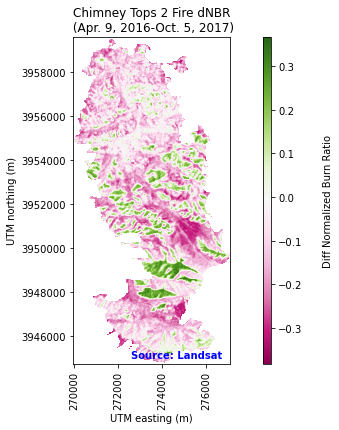

In [10]:
# Plot dNBR
fig, ax = plt.subplots(figsize=(12, 6))

plot = ax.imshow(dnbr,
                 extent=landsat_extent,
                 cmap='PiYG')

# Color bar settings
cbar = plt.colorbar(plot, aspect=40)
cbar.set_label('Diff Normalized Burn Ratio', rotation=90, labelpad=20)

# Remove scientific notation from tile coordinates
ax.ticklabel_format(useOffset=False, style='plain')

# Set figure title and axes labels
ax.set(
    title='Chimney Tops 2 Fire dNBR\n (Apr. 9, 2016-Oct. 5, 2017)',
    xlabel='UTM easting (m)',
    ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90)

# Data source caption
ax.text(.95, .01, "Source: Landsat", va='bottom',
        ha='right', transform=ax.transAxes, color="blue", fontweight="bold")

plt.show()

### 2. Normalized Difference Vegetation Index (NDVI)
* NDVI uses the spectral response of vegetation to quantity the greenness of an area.
* $NDVI=\frac{(NIR-Red)}{(NIR+Red)}$
* The difference NDVI is the difference between the post-fire NDVI and the pre-fire NDVI.

In [11]:
# Calc ndvi and mask for clouds
post_ndvi = landsat.masked_norm_diff(
    all_post_bands, fire_bound_reproj, post_qa_path, cloud_values, calc='ndvi')
pre_ndvi = landsat.masked_norm_diff(
    all_pre_bands, fire_bound_reproj, pre_qa_path, cloud_values, calc='ndvi')

# Calculate diff ndvi
diff_ndvi = post_ndvi - pre_ndvi

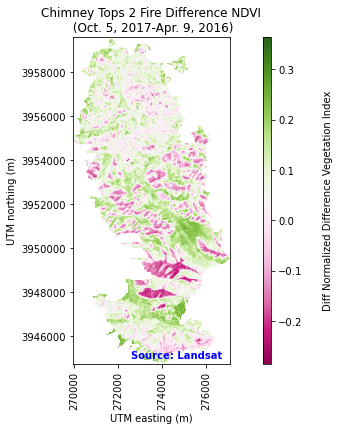

In [12]:
# Plot diff NDVI
fig, ax = plt.subplots(figsize=(12, 6))

plot = ax.imshow(diff_ndvi,
                 extent=landsat_extent,
                 cmap='PiYG')

# Color bar settings
cbar = plt.colorbar(plot, aspect=40)
cbar.set_label('Diff Normalized Difference Vegetation Index', rotation=90, 
               labelpad=20)

# Remove scientific notation from tile coordinates
ax.ticklabel_format(useOffset=False, style='plain')

# Set figure title and axes labels
ax.set(
    title='Chimney Tops 2 Fire Difference NDVI\n (Oct. 5, 2017-Apr. 9, 2016)',
    xlabel='UTM easting (m)',
    ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90)

# Data source caption
ax.text(.95, .01, "Source: Landsat", va='bottom',
         ha='right', transform=ax.transAxes, color="blue", fontweight="bold")

plt.show()

### 3. Modified Soil Adjusted Vegetation Index (MSAVI)
* MSAVI is a vegetation index in which the soil-noise background is minimized using a factor that varies inversely with the amount of vegetation present.
* The MSAVI equation has been expanded for ease of computation from its original form of
$\frac{2NIR+1-\sqrt{(2NIR + 1)^{2}-8(NIR-Red)}}{2}$ to $NIR+0.5-0.5\sqrt{4NIR^{2}-4NIR+8Red+1}$
* The difference MSAVI is the difference between the post-fire NDVI and the pre-fire NDVI.

In [13]:
# Calculate msavi
post_msavi = landsat.masked_msavi(
    all_post_bands, fire_bound_reproj, post_qa_path, cloud_values)
pre_msavi = landsat.masked_msavi(
    all_pre_bands, fire_bound_reproj, pre_qa_path, cloud_values)

# Calculate diff msavi
diff_msavi = post_msavi - pre_msavi

In [14]:
type(diff_msavi)

xarray.core.dataarray.DataArray

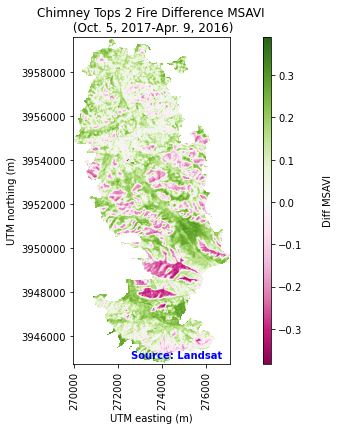

In [14]:
# Plot diff MSAVI
fig, ax = plt.subplots(figsize=(12, 6))

plot = plt.imshow(diff_msavi,
                  extent=landsat_extent,
                  cmap='PiYG')

# Color bar settings
cbar = plt.colorbar(plot, aspect=40)
cbar.set_label('Diff MSAVI', rotation=90, labelpad=20)

# Remove scientific notation from tile coordinates
ax.ticklabel_format(useOffset=False, style='plain')

# Set figure title and axes labels
ax.set(
    title='Chimney Tops 2 Fire Difference MSAVI\n (Oct. 5, 2017-Apr. 9, 2016)',
    xlabel='UTM easting (m)',
    ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90)

# Data source caption
ax.text(.95, .01, "Source: Landsat", va='bottom',
         ha='right', transform=ax.transAxes, color="blue", fontweight="bold")

plt.show()

### In order to compare to the NEON 1-km<sup>2</sup> reflectance tiles, here we make a shapefile in order to crop our Landsat data to a 1-km<sup>2</sup> area with the same spatial coordinates using geopandas and the Polygon constructor from the shapely library.

In [15]:
# Try making polygon to clip landsat data
coords = [(274000, 3947000), (275000, 3947000),
          (275000, 3948000), (274000, 3948000)]
polygon = Polygon(coords)
gdf = gpd.GeoDataFrame(index=[0], crs='epsg:32617', geometry=[polygon])
#gdf.to_file(os.path.join(project_path, 'outputs', 'tile_274000_3947000.shp'))

In [16]:
neon_clip_path = os.path.join(
    project_path, 'outputs', 'tile_274000_3947000.shp')
neon_clip = gpd.read_file(neon_clip_path)
neon_clip.crs

<Derived Projected CRS: EPSG:32617>
Name: WGS 84 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°W and 78°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Ecuador - north of equator. Canada - Nunavut; Ontario; Quebec. Cayman Islands. Colombia. Costa Rica. Cuba. Jamaica. Nicaragua. Panama. United States (USA).
- bounds: (-84.0, 0.0, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Now we can crop our Landsat data to the same size and same spatial coordinates using this shapefile. First, we can crop our dNBR plot.

In [17]:
# Clip dnbr
dnbr_clip = dnbr.rio.clip(neon_clip.geometry)

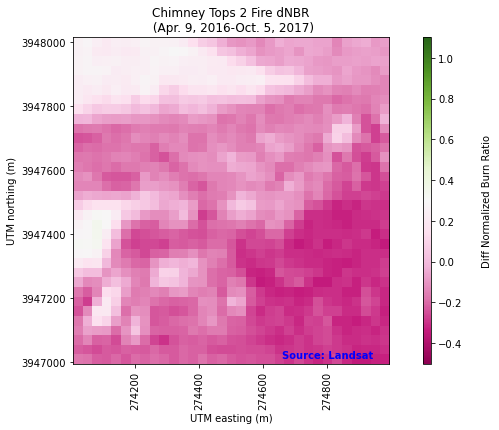

In [19]:
# Define the clip plot extent
clip_extent = plotting_extent(
    dnbr_clip, dnbr_clip.rio.transform())

# Plot dNBR
fig, ax = plt.subplots(figsize=(12, 6))

plot = ax.imshow(dnbr_clip,
                  extent=clip_extent,
                  cmap='PiYG')

# Color bar settings
cbar = plt.colorbar(plot, aspect=40)
cbar.set_label('Diff Normalized Burn Ratio', rotation=90, labelpad=20)
plot.set_clim(-0.5, 1.1)

# Remove scientific notation from tile coordinates
ax.ticklabel_format(useOffset=False, style='plain')

# Set figure title and axes labels
ax.set(
    title='Chimney Tops 2 Fire dNBR\n (Apr. 9, 2016-Oct. 5, 2017)',
    xlabel='UTM easting (m)',
    ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90)

# Data source caption
ax.text(.95, .01, "Source: Landsat", va='bottom',
         ha='right', transform=ax.transAxes, color="blue", fontweight="bold")

plt.show()

* The plot of the difference between the pre-post NBR for Landsat data suggest that almost all of the area has begun recovery since there is little dNBR greater than 0.

### Next, we can crop the difference NDVI plot.

In [21]:
# Clip diff ndvi
diff_ndvi_clip = diff_ndvi.rio.clip(neon_clip.geometry)

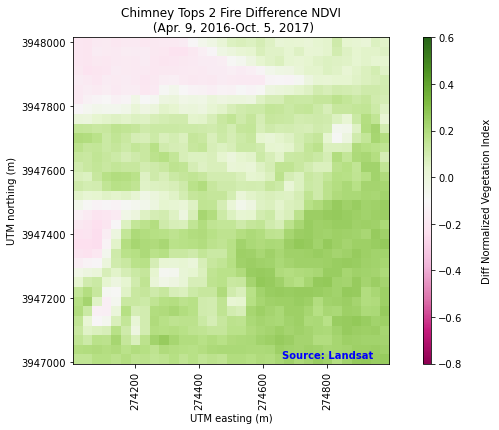

In [23]:
# Plot diff NDVI
fig, ax = plt.subplots(figsize=(12, 6))

plot = ax.imshow(diff_ndvi_clip,
                 extent=clip_extent,
                 cmap='PiYG')

# Color bar settings
cbar = plt.colorbar(plot, aspect=40)
cbar.set_label('Diff Normalized Vegetation Index', rotation=90, labelpad=20)
plot.set_clim(-0.8, 0.6)

# Remove scientific notation from tile coordinates
ax.ticklabel_format(useOffset=False, style='plain')

# Set figure title and axes labels
ax.set(
    title='Chimney Tops 2 Fire Difference NDVI\n (Apr. 9, 2016-Oct. 5, 2017)',
    xlabel='UTM easting (m)',
    ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90)

# Data source caption
ax.text(.95, .01, "Source: Landsat", va='bottom',
         ha='right', transform=ax.transAxes, color="blue", fontweight="bold")

plt.show()

* The plot of the post-pre NDVI shows very little loss of greenness almost a year after the Chimney Tops 2 Fire. The most significant loss of vegetation are shown in pink.

### Lastly, we can crop the difference MSAVI plot.

In [24]:
# Clip diff msavi
diff_msavi_clip = diff_msavi.rio.clip(neon_clip.geometry)

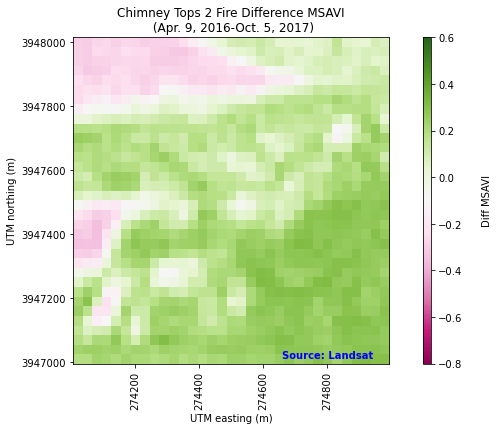

In [26]:
# Plot diff MSAVI
fig, ax = plt.subplots(figsize=(12, 6))

plot = ax.imshow(diff_msavi_clip,
                 extent=clip_extent,
                 cmap='PiYG')

# Color bar settings
cbar = plt.colorbar(plot, aspect=40)
cbar.set_label('Diff MSAVI', rotation=90, labelpad=20)
plot.set_clim(-0.8, 0.6)

# Remove scientific notation from tile coordinates
ax.ticklabel_format(useOffset=False, style='plain')

# Set figure title and axes labels
ax.set(
    title='Chimney Tops 2 Fire Difference MSAVI\n (Apr. 9, 2016-Oct. 5, 2017)',
    xlabel='UTM easting (m)',
    ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90)

# Data source caption
ax.text(.95, .01, "Source: Landsat", va='bottom',
         ha='right', transform=ax.transAxes, color="blue", fontweight="bold")

plt.show()

* The difference in post-pre MSAVI plot for Landsat data shows that the Chimney Tops region has little recovery remaining within one year after the fire. MSAVI takes into account the soil-noise background. This difference MSAVI plot suggests that the soil-noise background should be minimal since there is significant regrowth.